### Preview:

From the previous Part in SQL we found the Trip duration for rides from the `Loop` neighborhood to the `O'Hare` International Airport on Saturdays with consideration to the weather condition and by calculationg the average duration based on condition we can find the following:
1. **GOOD:** 1999.67
2. **BAD:** 2427.20

Based on the average above we can say that the duration of rides from the the Loop to O'Hare International Airport changes on rainy Saturdays but this alone is not enough as it is based solely on the average without factoring if the difference is significant therefore we will continue our work in Python after exporting the data from the SQL Database and our work here will include the following: 


**[Step 4. Exploratory data analysis](#Step-4.-Exploratory-data-analysis)**

we have the following datasets:

`/datasets/project_sql_result_01.csv`. It contains the following data:
- **company_name:** taxi company name
- **trips_amount:** the number of rides for each taxi company on November 15-16, 2017.

`/datasets/project_sql_result_04.csv`. It contains the following data:
- **dropoff_location_name:** Chicago neighborhoods where rides ended
- **average_trips:** the average number of rides that ended in each neighborhood in November 2017.

For these two datasets we will:

1. Import the files
2. Study the data they contain
3. Make sure the data types are correct
4. [Identify the top 10 neighborhoods in terms of dropoffs](#Identify-the-top-10-neighborhoods-in-terms-of-dropoffs)
5. [Make graphs: taxi companies and number of rides, top 10 neighborhoods by number of dropoffs](#Make-Graphs)
6. [Draw conclusions based on each graph and explain the results](#EDA-Conclusion)

**[Step 5. Testing hypotheses (Python)](#Step-5.-Testing-hypotheses-(Python))**


`/datasets/project_sql_result_07.csv` — the result of our last query in SQL. It contains data on rides from the Loop to O'Hare International Airport. These are the table's field values:
- **start_ts:** pickup date and time
- **weather_conditions:** weather conditions at the moment the ride started
- **duration_seconds:** ride duration in seconds

We will Test the hypothesis:
***The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.***

**[Step 6. Final Conclusion](#Step-6.-Final-Conclusion)**

Here we will draw our final conclusion and see if we can suggest some changes to improve the new company **Zuber**.

# Step 4. Exploratory data analysis

First of all we will read the 2 CSV Files that we have and check the data for missing values, duplicates and data types.

In [1]:
!pip install --upgrade --quiet seaborn
!pip install --upgrade --quiet scipy

In [2]:
import pandas as pd
import numpy as mp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene

In [3]:
company = pd.read_csv('/datasets/project_sql_result_01.csv')
neighborhood = pd.read_csv('/datasets/project_sql_result_04.csv')

In [4]:
company.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [5]:
neighborhood.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [6]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


We will start with the first Dataset <mark>company</mark>:  
- it contains 2 columns (with self explanatory names)
- it has 64 rows with no missing values.
- data type is ok but we can change it for the column `trips_amount` to int32 or even int 16 to save some memory
- `company_name` will be changed to lower case to make sure there are no duplicates that are being overlooked because of the letter's case.

In [7]:
company['trips_amount'] = company['trips_amount'].astype('int32')
company['company_name'] = company['company_name'].str.lower()
company.head()

,company_name,trips_amount
0,flash cab,19558
1,taxi affiliation services,11422
2,medallion leasing,10367
3,yellow cab,9888
4,taxi affiliation service yellow,9299


In [8]:
# now lets make sure that all the companies are unique
company['company_name'].nunique() == len(company)

True

In [9]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int32
dtypes: int32(1), object(1)
memory usage: 896.0+ bytes


In [10]:
company['trips_amount'].describe()

count       64.000000
mean      2145.484375
std       3812.310186
min          2.000000
25%         20.750000
50%        178.500000
75%       2106.500000
max      19558.000000
Name: trips_amount, dtype: float64

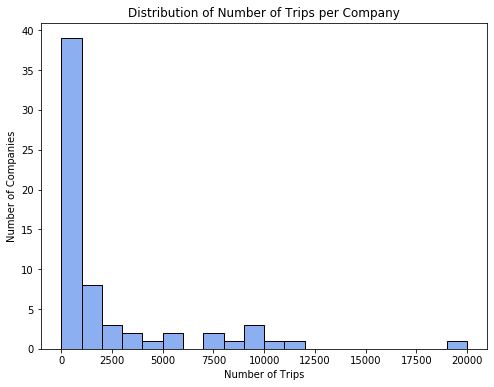

In [11]:
plt.figure(figsize = (8,6))
sns.histplot(data = company, x= 'trips_amount',binwidth =1000,
             bins=int(180/5), color = 'cornflowerblue')
plt.title('Distribution of Number of Trips per Company')
plt.xlabel("Number of Trips")
plt.ylabel("Number of Companies");

In [12]:
company.duplicated().sum()

0

In [13]:
neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_location_name    94 non-null object
average_trips            94 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


- data type was changed to int32 
- by looking at the description and the hist we can see that most of the companies in our data (75% of the companies) have less than 2150 trips with the one huge outlier reaching 19500 trip. 
- We will not exclude the outliers as we are studying the most popular companies which can be in these outliers.
- we dont have any duplicates in this dataset even after changing the names to lower case so we are clear here for now. 

Now we will jump to the next dataset <mark>neighborhood</mark>:
based on the info above we notice:
- it contains 2 columns: the names can be changed to make them clearer and easier to understand(will look into it). 
- it has 94 rows with no missing values.
- data type is ok for the `dropoff_location_name` but we can change it for the column `average_trips` from float to int as we are working with numbers of trips.
- `dropoff_location_name` will be changed to lower case to make sure there are no duplicates that are being overlooked because of the letter's case.

In [14]:
#the numbers should be automatically rounded to the closest integer.
neighborhood['average_trips'] = neighborhood['average_trips'].astype('int32') 
#changing the strings to lower case
neighborhood['dropoff_location_name'] = neighborhood['dropoff_location_name'].str.lower()

neighborhood.head()

,dropoff_location_name,average_trips
0,loop,10727
1,river north,9523
2,streeterville,6664
3,west loop,5163
4,o'hare,2546


In [15]:
# now lets make sure that all the dropoff location are unique 
neighborhood['dropoff_location_name'].nunique() == len(neighborhood)

True

In [16]:
neighborhood['average_trips'].describe()

count       94.000000
mean       599.478723
std       1714.555974
min          1.000000
25%         14.000000
50%         51.500000
75%        298.750000
max      10727.000000
Name: average_trips, dtype: float64

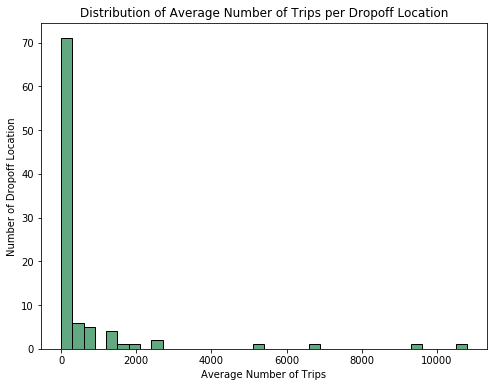

In [17]:
plt.figure(figsize = (8,6))
sns.histplot(data = neighborhood, x= 'average_trips',binwidth =300,
             bins=int(180/5), color = 'seagreen')
plt.title('Distribution of Average Number of Trips per Dropoff Location')
plt.xlabel("Average Number of Trips")
plt.ylabel("Number of Dropoff Location");

- data type was changed to int32 
- by looking at the description and the hist we can see that most of the Dropoff Locations in our data (75% of the Dropoff Locations) have less than 300 trips with few high outlier reaching 10700 trip. 
- We will not exclude the outliers as we are studying the top Dropoff Locations which can be in these outliers.
- We will change the name of the column to `neighborhood` to make it less confusing.

In [18]:
neighborhood.rename(columns={'dropoff_location_name': 'neighborhood'},inplace=True)
neighborhood.head()

,neighborhood,average_trips
0,loop,10727
1,river north,9523
2,streeterville,6664
3,west loop,5163
4,o'hare,2546


In [19]:
neighborhood.duplicated().sum()

0

- we dont have any duplicates in this dataset either even after changing the names to lower case so we are clear here for now. 
- now lets go a head and start our analysis.



### Identify the top 10 neighborhoods in terms of dropoffs

In [20]:
top_neighborhoods = neighborhood.sort_values('average_trips', ascending = False).head(10)
# lets calculate the overall market share
top_neighborhoods['overall_market_share'] = (top_neighborhoods['average_trips'] / neighborhood['average_trips'].sum()) * 100
# lets calculate the market share between the top 10 neighborhoods
top_neighborhoods['top_market_share'] = (top_neighborhoods['average_trips'] / top_neighborhoods['average_trips'].sum()) * 100
top_neighborhoods

,neighborhood,average_trips,overall_market_share,top_market_share
0,loop,10727,19.036042,24.805753
1,river north,9523,16.899434,22.021552
2,streeterville,6664,11.825877,15.410230
3,west loop,5163,9.162215,11.939229
4,o'hare,2546,4.518110,5.887522
5,lake view,2420,4.294511,5.596152
6,grant park,2068,3.669855,4.782166
7,museum campus,1510,2.679633,3.491814
8,gold coast,1364,2.420543,3.154195
9,sheffield & depaul,1259,2.234211,2.911387


above are the top 10 neighborhoods in terms of dropoffs. we can see that the number of dropoffs vary significantly between the first and last neighborhood. 

In [21]:
top_companies = company.sort_values('trips_amount', ascending = False).head(10)
# lets calculate the overall market share
top_companies['overall_market_share'] = (top_companies['trips_amount'] / company['trips_amount'].sum()) * 100
# lets calculate the market share between the top 10 companies
top_companies['market_share'] = (top_companies['trips_amount'] / top_companies['trips_amount'].sum()) * 100
top_companies

,company_name,trips_amount,overall_market_share,market_share
0,flash cab,19558,14.243578,19.701426
1,taxi affiliation services,11422,8.318343,11.505762
2,medallion leasing,10367,7.550014,10.443025
3,yellow cab,9888,7.201171,9.960513
4,taxi affiliation service yellow,9299,6.772218,9.367193
5,chicago carriage cab corp,9181,6.686282,9.248328
6,city service,8448,6.152457,8.509952
7,sun taxi,7701,5.608436,7.757474
8,star north management llc,7455,5.429281,7.509670
9,blue ribbon taxi association inc.,5953,4.335414,5.996656


above are the top 10 companies based on number of rides and market share

### Make Graphs

now we will make Graphs showing the tables above:
- Top 10 taxi companies and number of rides 
- Top 10 neighborhoods in terms of dropoffs.

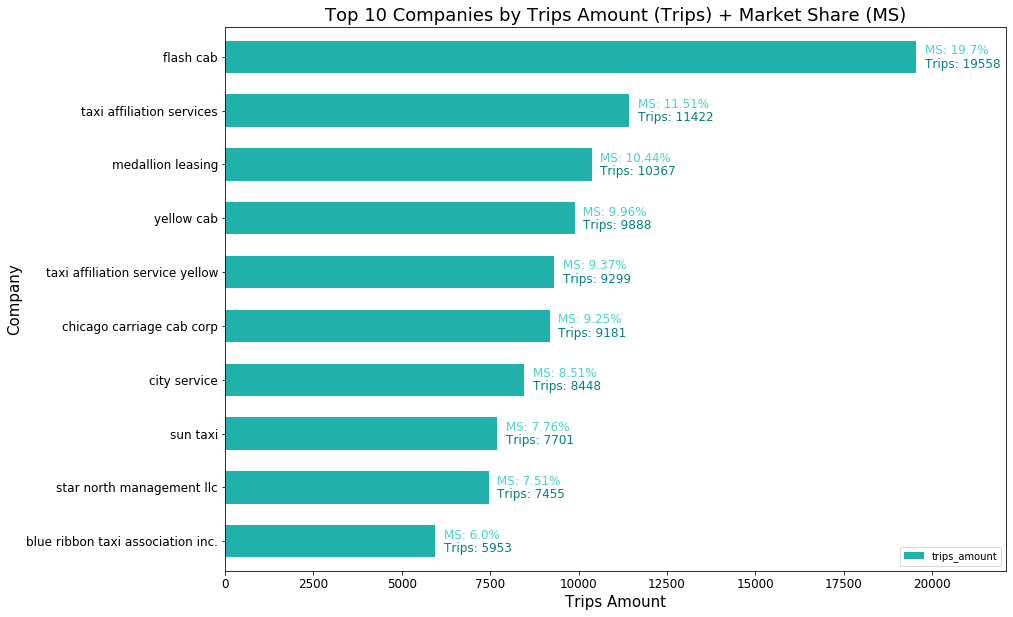

In [22]:
fig = top_companies.plot(x= 'company_name', y= 'trips_amount' ,kind='barh', figsize=(14,10), 
                                         color ="lightseagreen", fontsize=13, width=0.6);
fig.set_alpha(0.8)
fig.set_title("Top 10 Companies by Trips Amount (Trips) + Market Share (MS)", fontsize=18)
fig.set_ylabel("Company", fontsize=15);
fig.set_xlabel("Trips Amount", fontsize=15);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12)

fig.margins(0.13)

# to anotate with the values
for i in fig.patches:
    fig.annotate('Trips: ' + str(i.get_width()), ( i.get_width() + 250, i.get_y()+ 0.5 ), fontsize=12, color='teal') 
    
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in fig.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in fig.patches:
    # get_x pulls left or right; get_height pushes up or down
    fig.text(i.get_width() + 250 , i.get_y() + 0.25,'MS: ' + str(round((i.get_width()/total)*100, 2))+'%', fontsize=12, color='mediumturquoise')
    
fig.invert_yaxis() 

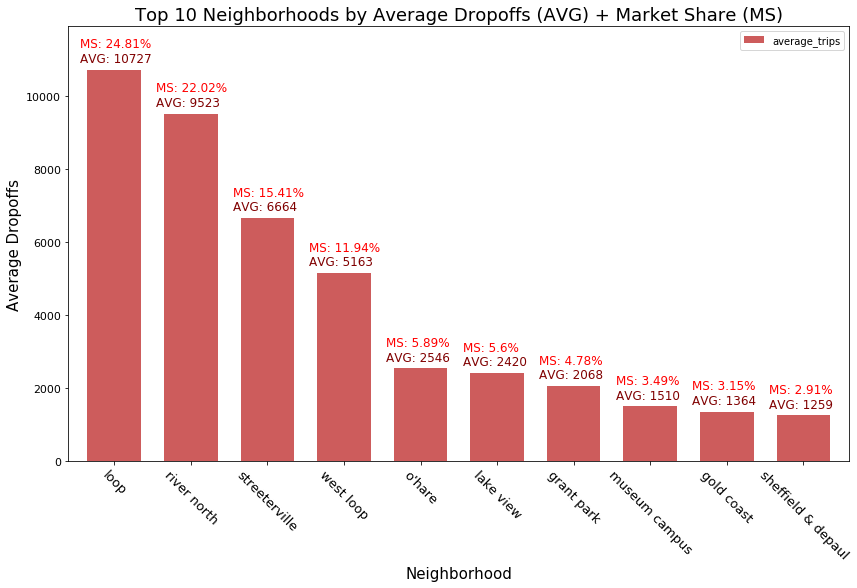

In [23]:
fig = top_neighborhoods.plot(x= 'neighborhood', y= 'average_trips' ,kind='bar', figsize=(14,8), 
                                         color ="indianred", fontsize=13, width=0.7);
fig.set_alpha(0.8)
fig.set_title("Top 10 Neighborhoods by Average Dropoffs (AVG) + Market Share (MS)", fontsize=18)
fig.set_ylabel("Average Dropoffs", fontsize=15);
fig.set_xlabel("Neighborhood", fontsize=15);
plt.xticks(rotation= -45 ,fontsize = 13);
plt.yticks(fontsize = 11);


fig.margins(0.11)

# to anotate with the values
for i in fig.patches:
    fig.annotate('AVG: ' + str(i.get_height()), (i.get_x()-0.1 , i.get_height() + 200), fontsize=12, color='maroon') 
    
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in fig.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in fig.patches:
    # get_x pulls left or right; get_height pushes up or down
    fig.text(i.get_x()- 0.1, i.get_height() + 600 , 'MS: ' + str(round((i.get_height()/total)*100, 2))+'%', fontsize=12, color='red')

### EDA Conclusion

#### Taxi Companies:

- we can see that `flash cab` takes the lead and with a huge difference from the second and with almost double the amount of rides of the third.
- `flash cab` controls around 15% of the overall market share and 20% of the top 10 market which is almost double or more any other company
- for the following companies we notice a consistent decrease of the amount of rides with around 1000 ride.
- it will be best if we focus on `flash cab` strategy as they are the leading taxi company in Chicago

#### Dropoffs Neighborhoods:

- we can see that the `loop` neighborhood comes first in terms of average dropoffs then comes `river north` with a 3000 difference with the third.
- third and fourth neighborhoods have a relatively close average but then we have another big gap with the fifth.
- considering the market share ( both the overall or market share between the top 10) we can see the market are so focused on the top 4 neighborhoods.
- If we take a look on the geogrphical distribution of the top neighborhoods in this [**map**](https://www.choosechicago.com/neighborhoods/) we notice that they are located in the same Distisrict/Area or at least next to each other which is considerd <mark>Downtown Chicago</mark> therefore it is not exactly strange for these neighborhoods to be the most common dropoff locations.



# Step 5. Testing hypotheses (Python)

Now we will Test the hypothesis: The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.  
to do so we will start by checking the new data in  `/datasets/project_sql_result_07.csv` — which is the result of our last query in SQL

In [24]:
loop_hare = pd.read_csv('/datasets/project_sql_result_07.csv')
loop_hare.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [25]:
loop_hare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null object
weather_conditions    1068 non-null object
duration_seconds      1068 non-null float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [26]:
loop_hare['weather_conditions'].value_counts()

Good    888
Bad     180
Name: weather_conditions, dtype: int64

After a quick look at the Dataset <mark>loop_hare</mark>:  
- it contains 3 columns (with self explanatory names)
- it has 1068 rows with no missing values.
- data types need to be changed as follows:
  1. `start_ts`: datetime
  2. `weather_conditions`: Category as it contains only 2 values [Good - Bad]
  3. `duration_seconds`: Int16
 

In [27]:
loop_hare['start_ts'] = pd.to_datetime(loop_hare['start_ts'])
loop_hare['weather_conditions'] = loop_hare['weather_conditions'].astype('category')
loop_hare['duration_seconds'] = loop_hare['duration_seconds'].astype('int16')
loop_hare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null datetime64[ns]
weather_conditions    1068 non-null category
duration_seconds      1068 non-null int16
dtypes: category(1), datetime64[ns](1), int16(1)
memory usage: 11.7 KB


In [28]:
loop_hare.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410
1,2017-11-25 14:00:00,Good,1920
2,2017-11-25 12:00:00,Good,1543
3,2017-11-04 10:00:00,Good,2512
4,2017-11-11 07:00:00,Good,1440


now lets check the values in the dataset and see if they need some work and preparation

In [29]:
loop_hare['start_ts'].value_counts().head()

2017-11-11 10:00:00    48
2017-11-04 14:00:00    46
2017-11-04 12:00:00    46
2017-11-11 06:00:00    45
2017-11-11 08:00:00    43
Name: start_ts, dtype: int64

it looks like we have several trips with the same timestamp as these are the results of our last query in the SQL, I went back and checked if they have different trip_id to make sure they are not duplicates and they are actually different trips with different id so no problem here. 

In [30]:
loop_hare.groupby('weather_conditions')['duration_seconds'].describe()

,count,mean,std,min,25%,50%,75%,max
weather_conditions,,,,,,,,
Bad,180.0,2427.205556,721.314138,480.0,1962.00,2540.0,2928.0,4980.0
Good,888.0,1999.675676,759.198268,0.0,1389.75,1800.0,2460.0,7440.0


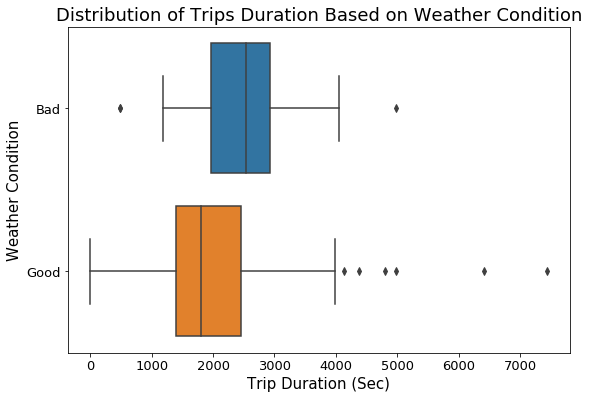

In [31]:
plt.figure(figsize = (9,6))
fig = sns.boxplot(data = loop_hare, x= 'duration_seconds' ,y = 'weather_conditions')
fig.set_title('Distribution of Trips Duration Based on Weather Condition' , fontsize = 18)
fig.set_ylabel("Weather Condition", fontsize=15);
fig.set_xlabel("Trip Duration (Sec)", fontsize=15);
plt.xticks(fontsize = 13);
plt.yticks(fontsize = 13);

As we will use Student-test in our hypothesis and for the results to be more acurate it is best practice to remopve the outliers first and according to the description and the box plot above we can notice:
1. for the `Bad` weather condition the median is slightly higher than the mean which indicates that the values are normaly distributed and from the box plot we see that we have a couple of outliers one on each side.
2. for the `Good` weather condition the mean is higher than the median and after looking at the box plot we can see that the values are normaly distributed with some high outliers.

as the outliers are not much we can just ignore them but we are gonna remove them to have the most accurate results for our hypothesis test.

In [32]:
Q1_Good = loop_hare[loop_hare['weather_conditions'] == 'Good']['duration_seconds'].quantile(0.25)
Q3_Good = loop_hare[loop_hare['weather_conditions'] == 'Good']['duration_seconds'].quantile(0.75)
IQR_Good = Q3_Good - Q1_Good
bottom_limit_Good = Q1_Good - (1.5*IQR_Good)
upper_limit_Good = Q3_Good + (1.5*IQR_Good)
if bottom_limit_Good < 0:
    bottom_limit_Good = 0
    
Q1_Bad = loop_hare[loop_hare['weather_conditions'] == 'Bad']['duration_seconds'].quantile(0.25)
Q3_Bad = loop_hare[loop_hare['weather_conditions'] == 'Bad']['duration_seconds'].quantile(0.75)
IQR_Bad = Q3_Bad - Q1_Bad
bottom_limit_Bad= Q1_Bad - (1.5*IQR_Bad)
upper_limit_Bad = Q3_Bad + (1.5*IQR_Bad)
if bottom_limit_Bad < 0:
    bottom_limit_Bad = 0

In [33]:
loop_hare_no_outliers = loop_hare.loc[((loop_hare['weather_conditions'] == 'Good') & (loop_hare['duration_seconds'] > bottom_limit_Good) & (loop_hare['duration_seconds'] < upper_limit_Good))
             | ((loop_hare['weather_conditions'] == 'Bad') & (loop_hare['duration_seconds'] > bottom_limit_Bad) & (loop_hare['duration_seconds'] < upper_limit_Bad))]

In [34]:
loop_hare_no_outliers.groupby('weather_conditions')['duration_seconds'].describe()

,count,mean,std,min,25%,50%,75%,max
weather_conditions,,,,,,,,
Bad,177.0,2434.785311,670.068237,1182.0,1980.00,2560.0,2926.0,4044.0
Good,876.0,1990.356164,685.419634,60.0,1394.25,1800.0,2460.0,3982.0


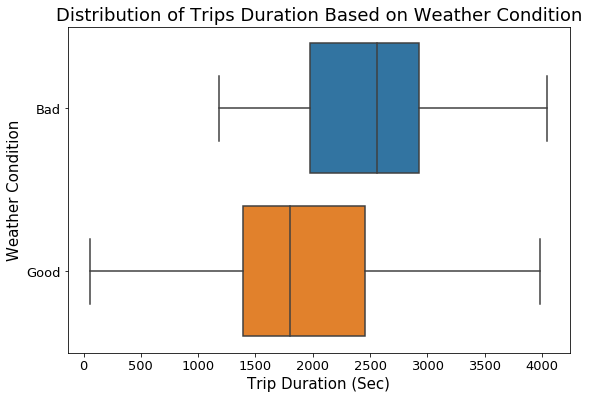

In [35]:
plt.figure(figsize = (9,6))
fig = sns.boxplot(data = loop_hare_no_outliers, x= 'duration_seconds' ,y = 'weather_conditions')
fig.set_title('Distribution of Trips Duration Based on Weather Condition' , fontsize = 18)
fig.set_ylabel("Weather Condition", fontsize=15);
fig.set_xlabel("Trip Duration (Sec)", fontsize=15);
plt.xticks(fontsize = 13);
plt.yticks(fontsize = 13);

we will now split the data in 2 Datasets based on weather condition

In [36]:
Bad = loop_hare_no_outliers[loop_hare_no_outliers['weather_conditions'] == 'Bad']['duration_seconds']
Good = loop_hare_no_outliers[loop_hare_no_outliers['weather_conditions'] == 'Good']['duration_seconds']

lets check if our data is distributed normally and for that we will use shapiro Test.

we will test both datasets and our hypothesises will be:

- H0: dataset is distributed normaly 
- H1: dataset is NOT distributed normaly  

we will use a standard critical statistical significance level (alpha= 0.05)

In [37]:
alpha = 0.05

bad_normality = st.shapiro(Bad)

print('p-value: ', bad_normality.pvalue)

if (bad_normality.pvalue > alpha):
    print('Data looks Normal (fail to reject H0)')
else:
    print('Data does not look Normal (reject H0)')    

p-value:  0.0002595653641037643
Data does not look Normal (reject H0)


In [38]:
alpha = 0.05

Good_normality = st.shapiro(Good)

print('p-value: ', Good_normality.pvalue)

if (bad_normality.pvalue > alpha):
    print('Data looks Normal (fail to reject H0)')
else:
    print('Data does not look Normal (reject H0)')  

p-value:  1.578696009483761e-20
Data does not look Normal (reject H0)


Based on the tests above we see that both of our datasets don't look normal so we will use Levene-Test to check if the variances are equal on both sets.

for this this test we will be forming the following hypothesis:
- H0: Variances are equal
- H1: Variances are Different 

we will use a standard critical statistical significance level (alpha= 0.05)  

- to decide which variation of the Test we will use lets take a look at the hist for both of the sets and then we will decide as follows:  
1. median: recommended for skewed distributions.
2. mean: recommended for symmetric, moderate-tailed distributions.
3. trimmed: recommended for heavy-tailed distributions.

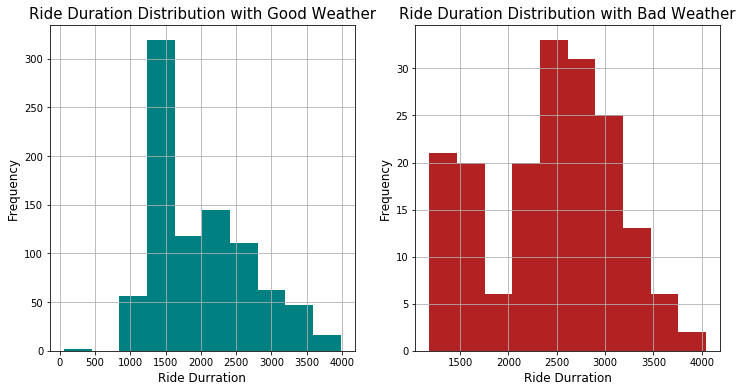

In [39]:
plt.figure(figsize = (12,6));
plt.subplot(1, 2, 1);
fig1 = Good.hist(color = 'teal');
plt.title('Ride Duration Distribution with Good Weather', fontsize = 15);
fig1.set_ylabel("Frequency", fontsize=12);
fig1.set_xlabel("Ride Durration", fontsize=12);

plt.subplot(1, 2, 2);
fig2 = Bad.hist(color = 'firebrick');
plt.title('Ride Duration Distribution with Bad Weather', fontsize = 15);
fig2.set_ylabel("Frequency", fontsize=12);
fig2.set_xlabel("Ride Durration", fontsize=12);

Based on the Hists above we can see that both of our sets are skewed so we will use the Median Variation but we will test with the mean also to double check

In [40]:
alpha = 0.05

variance_equality = st.levene(Good, Bad , center = 'median')

print('p-value: ', variance_equality.pvalue)

if (variance_equality.pvalue < alpha):
        print("We reject the null hypothesis and the variances are different ")
else:
        print("We can't reject the null hypothesis therefore the variances are equal") 

p-value:  0.48389565052589256
We can't reject the null hypothesis therefore the variances are equal


In [41]:
alpha = 0.05

variance_equality = st.levene(Good, Bad , center = 'mean')

print('p-value: ', variance_equality.pvalue)

if (variance_equality.pvalue < alpha):
        print("We reject the null hypothesis and the variances are different ")
else:
        print("We can't reject the null hypothesis therefore the variances are equal") 

p-value:  0.3358645473312948
We can't reject the null hypothesis therefore the variances are equal


in both cases we couldn't reject the null hypothesis so we will consider that the variances in both datasets are equal and now we check our main Hypothesis using Student-Test with consideration that the variances are equal.

Our hypothesis is: ***The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.***

for this this test we will be forming the following hypothesis:
- H0: average duration of rides in (Good) weather days == average duration of rides in (Bad) weather days
- H1: average duration of rides in (Good) weather days != average duration of rides in (Bad) weather days

we will use a standard critical statistical significance level (alpha= 0.05) 

In [42]:
alpha = 0.05

results = st.ttest_ind(Good, Bad, equal_var = True)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis and the average duration of rides changes on rainy days")
else:
        print("We can't reject the null hypothesis therefore we cann't say that the average duration of rides changes on rainy days") 

p-value:  7.134804780778323e-15
We reject the null hypothesis and the average duration of rides changes on rainy days


- based on the Student-Test we can say that the difference in the average duration of rides is significant and the average duration of rides changes on rainy days.
- Based on the average taken from the descriptioon table above we can see that the average duration of rides on days with bad weather is longer than that on days with good weather which point out that the average is not only different but also longer in general.

# Step 6. Final Conclusion

As a new ride-sharing company **Zuber** we can recommend the following:

- **Location:** it is clear that the Downtown area is the most popular dropoff location which makes it also one of the most probable location to get a cab for going back home. Therefore it is recommended that the company takes this into consideration and the following measures can be implemented if possible: 
    1. increase the number of available cars in this area 
    2. implement a fare-rate system that will decrease the rate while going toward this area and increase it the further away as it is more likely for the car going away to return empty or wait for a longer to get a new customer than the cars going towrds Downtown  


- **Company and partnerships:** as it is not clear which system the company is planning to adopt (partnering with existing companies or hire independent drivers) therefore the following can be considered:
    1. a partnership with `Flash Cab` as it is the leading company in chicago in this line of expertise
    2. try to work with the smaller companies but adopting a new marketing and work system based on the system of `Flash Cab` as it has proven itself effective
    3. steer away from existing companies and work solely with independent drivers while adopting a system that will control the rate and area of work for each driver  


- **Weather Condition:** as per our test before it is clear that the condition affects the duration of a ride which makes it less profitable as it means less rides per day therefore it is recommended to implement a system which also consider the length of the ride and not just the length.